<a href="https://colab.research.google.com/github/BoyoungH/2D-to-3D-Nerf/blob/main/tiny_nerf_update_model(nerfpl).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install git+https://github.com/aliutkus/torchsearchsorted
import torchsearchsorted

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/aliutkus/torchsearchsorted to /tmp/pip-req-build-ip09s2ri
  Running command git clone --filter=blob:none --quiet https://github.com/aliutkus/torchsearchsorted /tmp/pip-req-build-ip09s2ri
  Resolved https://github.com/aliutkus/torchsearchsorted to commit 22b628aa348abb854aef8660fed67d98b7676fc9
  Preparing metadata (setup.py) ... done
  Created wheel for torchsearchsorted: filename=torchsearchsorted-1.1-cp310-cp310-linux_x86_64.whl size=6547255 sha256=69989b37af13910bd08d69c99f6a852639c9bb82a11fea61481228c1f8b8dde2
  Stored in directory: /tmp/pip-ephem-wheel-cache-6nffvzrj/wheels/66/03/bf/287777e30536367f12403b7ecbb6eb92dc5045053c9132cece
Successfully built torchsearchsorted


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from torch import nn, optim

def get_coarse_query_points(ds, N_c, t_i_c_bin_edges, t_i_c_gap, os):
    u_is_c = torch.rand(*list(ds.shape[:2]) + [N_c]).to(ds)
    t_is_c = t_i_c_bin_edges + u_is_c * t_i_c_gap
    r_ts_c = os[..., None, :] + t_is_c[..., :, None] * ds[..., None, :]
    return (r_ts_c, t_is_c)


def get_fine_query_points(w_is_c, N_f, t_is_c, t_f, os, ds):
    w_is_c = w_is_c + 1e-5
    pdfs = w_is_c / torch.sum(w_is_c, dim=-1, keepdim=True)
    cdfs = torch.cumsum(pdfs, dim=-1)
    cdfs = torch.cat([torch.zeros_like(cdfs[..., :1]), cdfs[..., :-1]], dim=-1)

    us = torch.rand(list(cdfs.shape[:-1]) + [N_f]).to(w_is_c)

    idxs = torch.searchsorted(cdfs, us, right=True)
    t_i_f_bottom_edges = torch.gather(t_is_c, 2, idxs - 1)
    idxs_capped = idxs.clone()
    max_ind = cdfs.shape[-1]
    idxs_capped[idxs_capped == max_ind] = max_ind - 1
    t_i_f_top_edges = torch.gather(t_is_c, 2, idxs_capped)
    t_i_f_top_edges[idxs == max_ind] = t_f
    t_i_f_gaps = t_i_f_top_edges - t_i_f_bottom_edges
    u_is_f = torch.rand_like(t_i_f_gaps).to(os)
    t_is_f = t_i_f_bottom_edges + u_is_f * t_i_f_gaps

    (t_is_f, _) = torch.sort(torch.cat([t_is_c, t_is_f.detach()], dim=-1), dim=-1)
    r_ts_f = os[..., None, :] + t_is_f[..., :, None] * ds[..., None, :]
    return (r_ts_f, t_is_f)


def render_radiance_volume(r_ts, ds, chunk_size, F, t_is):
    r_ts_flat = r_ts.reshape((-1, 3))
    ds_rep = ds.unsqueeze(2).repeat(1, 1, r_ts.shape[-2], 1)
    ds_flat = ds_rep.reshape((-1, 3))
    c_is = []
    sigma_is = []
    for chunk_start in range(0, r_ts_flat.shape[0], chunk_size):
        r_ts_batch = r_ts_flat[chunk_start : chunk_start + chunk_size]
        ds_batch = ds_flat[chunk_start : chunk_start + chunk_size]
        preds = F(r_ts_batch, ds_batch)
        c_is.append(preds["c_is"])
        sigma_is.append(preds["sigma_is"])

    c_is = torch.cat(c_is).reshape(r_ts.shape)
    sigma_is = torch.cat(sigma_is).reshape(r_ts.shape[:-1])
    delta_is = t_is[..., 1:] - t_is[..., :-1]
    one_e_10 = torch.Tensor([1e10]).expand(delta_is[..., :1].shape)
    delta_is = torch.cat([delta_is, one_e_10.to(delta_is)], dim=-1)
    delta_is = delta_is * ds.norm(dim=-1).unsqueeze(-1)
    alpha_is = 1.0 - torch.exp(-sigma_is * delta_is)
    T_is = torch.cumprod(1.0 - alpha_is + 1e-10, -1)
    T_is = torch.roll(T_is, 1, -1)
    T_is[..., 0] = 1.0
    w_is = T_is * alpha_is
    C_rs = (w_is[..., None] * c_is).sum(dim=-2)

    return (C_rs, w_is)


def run_one_iter_of_nerf(
    ds, N_c, t_i_c_bin_edges, t_i_c_gap, os, chunk_size, F_c, N_f, t_f, F_f
):
    (r_ts_c, t_is_c) = get_coarse_query_points(ds, N_c, t_i_c_bin_edges, t_i_c_gap, os)
    (C_rs_c, w_is_c) = render_radiance_volume(r_ts_c, ds, chunk_size, F_c, t_is_c)

    (r_ts_f, t_is_f) = get_fine_query_points(w_is_c, N_f, t_is_c, t_f, os, ds)
    (C_rs_f, _) = render_radiance_volume(r_ts_f, ds, chunk_size, F_f, t_is_f)

    return (C_rs_c, C_rs_f)

class NeRFMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.L_pos = 10
        self.L_dir = 4
        pos_enc_feats = 3 + 3 * 2 * self.L_pos
        dir_enc_feats = 3 + 3 * 2 * self.L_dir

        in_feats = pos_enc_feats
        net_width = 256
        early_mlp_layers = 1
        early_mlp = []
        for layer_idx in range(early_mlp_layers):
            early_mlp.append(nn.Linear(in_feats, net_width))
            early_mlp.append(nn.ReLU())
            in_feats = net_width

        self.early_mlp = nn.Sequential(*early_mlp)

        in_feats = pos_enc_feats + net_width
        late_mlp_layers = 1
        late_mlp = []
        for layer_idx in range(late_mlp_layers):
            late_mlp.append(nn.Linear(in_feats, net_width))
            late_mlp.append(nn.ReLU())
            in_feats = net_width

        self.late_mlp = nn.Sequential(*late_mlp)
        self.sigma_layer = nn.Linear(net_width, net_width + 1)
        self.pre_final_layer = nn.Sequential(
            nn.Linear(dir_enc_feats + net_width, net_width // 2), nn.ReLU()
        )
        self.final_layer = nn.Sequential(nn.Linear(net_width // 2, 3), nn.Sigmoid())

    def forward(self, xs, ds):
        xs_encoded = [xs]
        for l_pos in range(self.L_pos):
            xs_encoded.append(torch.sin(2 ** l_pos * torch.pi * xs))
            xs_encoded.append(torch.cos(2 ** l_pos * torch.pi * xs))

        xs_encoded = torch.cat(xs_encoded, dim=-1)

        ds = ds / ds.norm(p=2, dim=-1).unsqueeze(-1)
        ds_encoded = [ds]
        for l_dir in range(self.L_dir):
            ds_encoded.append(torch.sin(2 ** l_dir * torch.pi * ds))
            ds_encoded.append(torch.cos(2 ** l_dir * torch.pi * ds))

        ds_encoded = torch.cat(ds_encoded, dim=-1)
        outputs = self.early_mlp(xs_encoded)
        outputs = self.late_mlp(torch.cat([xs_encoded, outputs], dim=-1))
        outputs = self.sigma_layer(outputs)
        sigma_is = torch.relu(outputs[:, 0])
        outputs = self.pre_final_layer(torch.cat([ds_encoded, outputs[:, 1:]], dim=-1))
        c_is = self.final_layer(outputs)
        return {"c_is": c_is, "sigma_is": sigma_is}

'''import torch
from torchsearchsorted import searchsorted

__all__ = ['render_rays']

def sample_pdf(bins, weights, N_importance, det=False, eps=1e-5):
    N_rays, N_samples_ = weights.shape
    weights = weights + eps # prevent division by zero (don't do inplace op!)
    pdf = weights / torch.sum(weights, -1, keepdim=True) # (N_rays, N_samples_)
    cdf = torch.cumsum(pdf, -1) # (N_rays, N_samples), cumulative distribution function
    cdf = torch.cat([torch.zeros_like(cdf[: ,:1]), cdf], -1)  # (N_rays, N_samples_+1)
                                                               # padded to 0~1 inclusive

    if det:
        u = torch.linspace(0, 1, N_importance, device=bins.device)
        u = u.expand(N_rays, N_importance)
    else:
        u = torch.rand(N_rays, N_importance, device=bins.device)
    u = u.contiguous()

    inds = searchsorted(cdf, u, side='right')
    below = torch.clamp_min(inds-1, 0)
    above = torch.clamp_max(inds, N_samples_)

    inds_sampled = torch.stack([below, above], -1).view(N_rays, 2*N_importance)
    cdf_g = torch.gather(cdf, 1, inds_sampled).view(N_rays, N_importance, 2)
    bins_g = torch.gather(bins, 1, inds_sampled).view(N_rays, N_importance, 2)

    denom = cdf_g[...,1]-cdf_g[...,0]
    denom[denom<eps] = 1 # denom equals 0 means a bin has weight 0, in which case it will not be sampled
                         # anyway, therefore any value for it is fine (set to 1 here)

    samples = bins_g[...,0] + (u-cdf_g[...,0])/denom * (bins_g[...,1]-bins_g[...,0])
    return samples


def render_rays(models,
                embeddings,
                rays,
                N_samples=64,
                use_disp=False,
                perturb=0,
                noise_std=1,
                N_importance=0,
                chunk=1024*32,
                white_back=False,
                test_time=False
                ):

    def inference(model, embedding_xyz, xyz_, dir_, dir_embedded, z_vals, weights_only=False):
        N_samples_ = xyz_.shape[1]
        # Embed directions
        xyz_ = xyz_.view(-1, 3) # (N_rays*N_samples_, 3)
        if not weights_only:
            dir_embedded = torch.repeat_interleave(dir_embedded, repeats=N_samples_, dim=0)
                           # (N_rays*N_samples_, embed_dir_channels)

        # Perform model inference to get rgb and raw sigma
        B = xyz_.shape[0]
        out_chunks = []
        for i in range(0, B, chunk):
            # Embed positions by chunk
            xyz_embedded = embedding_xyz(xyz_[i:i+chunk])
            if not weights_only:
                xyzdir_embedded = torch.cat([xyz_embedded,
                                             dir_embedded[i:i+chunk]], 1)
            else:
                xyzdir_embedded = xyz_embedded
            out_chunks += [model(xyzdir_embedded, sigma_only=weights_only)]

        out = torch.cat(out_chunks, 0)
        if weights_only:
            sigmas = out.view(N_rays, N_samples_)
        else:
            rgbsigma = out.view(N_rays, N_samples_, 4)
            rgbs = rgbsigma[..., :3] # (N_rays, N_samples_, 3)
            sigmas = rgbsigma[..., 3] # (N_rays, N_samples_)

        # Convert these values using volume rendering (Section 4)
        deltas = z_vals[:, 1:] - z_vals[:, :-1] # (N_rays, N_samples_-1)
        delta_inf = 1e10 * torch.ones_like(deltas[:, :1]) # (N_rays, 1) the last delta is infinity
        deltas = torch.cat([deltas, delta_inf], -1)  # (N_rays, N_samples_)

        # Multiply each distance by the norm of its corresponding direction ray
        # to convert to real world distance (accounts for non-unit directions).
        deltas = deltas * torch.norm(dir_.unsqueeze(1), dim=-1)

        noise = torch.randn(sigmas.shape, device=sigmas.device) * noise_std

        # compute alpha by the formula (3)
        alphas = 1-torch.exp(-deltas*torch.relu(sigmas+noise)) # (N_rays, N_samples_)
        alphas_shifted = \
            torch.cat([torch.ones_like(alphas[:, :1]), 1-alphas+1e-10], -1) # [1, a1, a2, ...]
        weights = \
            alphas * torch.cumprod(alphas_shifted, -1)[:, :-1] # (N_rays, N_samples_)
        weights_sum = weights.sum(1) # (N_rays), the accumulated opacity along the rays
                                     # equals "1 - (1-a1)(1-a2)...(1-an)" mathematically
        if weights_only:
            return weights

        # compute final weighted outputs
        rgb_final = torch.sum(weights.unsqueeze(-1)*rgbs, -2) # (N_rays, 3)
        depth_final = torch.sum(weights*z_vals, -1) # (N_rays)

        if white_back:
            rgb_final = rgb_final + 1-weights_sum.unsqueeze(-1)

        return rgb_final, depth_final, weights


    # Extract models from lists
    model_coarse = models[0]
    embedding_xyz = embeddings[0]
    embedding_dir = embeddings[1]

    # Decompose the inputs
    N_rays = rays.shape[0]
    rays_o, rays_d = rays[:, 0:3], rays[:, 3:6] # both (N_rays, 3)
    near, far = rays[:, 6:7], rays[:, 7:8] # both (N_rays, 1)

    # Embed direction
    dir_embedded = embedding_dir(rays_d) # (N_rays, embed_dir_channels)

    # Sample depth points
    z_steps = torch.linspace(0, 1, N_samples, device=rays.device) # (N_samples)
    if not use_disp: # use linear sampling in depth space
        z_vals = near * (1-z_steps) + far * z_steps
    else: # use linear sampling in disparity space
        z_vals = 1/(1/near * (1-z_steps) + 1/far * z_steps)

    z_vals = z_vals.expand(N_rays, N_samples)

    if perturb > 0: # perturb sampling depths (z_vals)
        z_vals_mid = 0.5 * (z_vals[: ,:-1] + z_vals[: ,1:]) # (N_rays, N_samples-1) interval mid points
        # get intervals between samples
        upper = torch.cat([z_vals_mid, z_vals[: ,-1:]], -1)
        lower = torch.cat([z_vals[: ,:1], z_vals_mid], -1)

        perturb_rand = perturb * torch.rand(z_vals.shape, device=rays.device)
        z_vals = lower + (upper - lower) * perturb_rand

    xyz_coarse_sampled = rays_o.unsqueeze(1) + \
                         rays_d.unsqueeze(1) * z_vals.unsqueeze(2) # (N_rays, N_samples, 3)

    if test_time:
        weights_coarse = \
            inference(model_coarse, embedding_xyz, xyz_coarse_sampled, rays_d,
                      dir_embedded, z_vals, weights_only=True)
        result = {'opacity_coarse': weights_coarse.sum(1)}
    else:
        rgb_coarse, depth_coarse, weights_coarse = \
            inference(model_coarse, embedding_xyz, xyz_coarse_sampled, rays_d,
                      dir_embedded, z_vals, weights_only=False)
        result = {'rgb_coarse': rgb_coarse,
                  'depth_coarse': depth_coarse,
                  'opacity_coarse': weights_coarse.sum(1)
                 }

    if N_importance > 0: # sample points for fine model
        z_vals_mid = 0.5 * (z_vals[: ,:-1] + z_vals[: ,1:]) # (N_rays, N_samples-1) interval mid points
        z_vals_ = sample_pdf(z_vals_mid, weights_coarse[:, 1:-1],
                             N_importance, det=(perturb==0)).detach()
                  # detach so that grad doesn't propogate to weights_coarse from here

        z_vals, _ = torch.sort(torch.cat([z_vals, z_vals_], -1), -1)

        xyz_fine_sampled = rays_o.unsqueeze(1) + \
                           rays_d.unsqueeze(1) * z_vals.unsqueeze(2)
                           # (N_rays, N_samples+N_importance, 3)

        model_fine = models[1]
        rgb_fine, depth_fine, weights_fine = \
            inference(model_fine, embedding_xyz, xyz_fine_sampled, rays_d,
                      dir_embedded, z_vals, weights_only=False)

        result['rgb_fine'] = rgb_fine
        result['depth_fine'] = depth_fine
        result['opacity_fine'] = weights_fine.sum(1)
        C_rs_c = result['rgb_coarse']
        C_rs_f = result['rgb_fine']

    return (C_rs_c, C_rs_f)

class Embedding(nn.Module):
    def __init__(self, in_channels, N_freqs, logscale=True):

        super(Embedding, self).__init__()
        self.N_freqs = N_freqs
        self.in_channels = in_channels
        self.funcs = [torch.sin, torch.cos]
        self.out_channels = in_channels*(len(self.funcs)*N_freqs+1)

        if logscale:
            self.freq_bands = 2**torch.linspace(0, N_freqs-1, N_freqs)
        else:
            self.freq_bands = torch.linspace(1, 2**(N_freqs-1), N_freqs)

    def forward(self, x):
        out = [x]
        for freq in self.freq_bands:
            for func in self.funcs:
                out += [func(freq*x)]

        return torch.cat(out, -1)


class NeRF(nn.Module):
    def __init__(self,
                 D=8, W=256,
                 in_channels_xyz=63, in_channels_dir=27,
                 skips=[4]):
        super(NeRF, self).__init__()
        self.D = D
        self.W = W
        self.in_channels_xyz = in_channels_xyz
        self.in_channels_dir = in_channels_dir
        self.skips = skips

        # xyz encoding layers
        for i in range(D):
            if i == 0:
                layer = nn.Linear(in_channels_xyz, W)
            elif i in skips:
                layer = nn.Linear(W+in_channels_xyz, W)
            else:
                layer = nn.Linear(W, W)
            layer = nn.Sequential(layer, nn.ReLU(True))
            setattr(self, f"xyz_encoding_{i+1}", layer)
        self.xyz_encoding_final = nn.Linear(W, W)

        # direction encoding layers
        self.dir_encoding = nn.Sequential(
                                nn.Linear(W+in_channels_dir, W//2),
                                nn.ReLU(True))

        # output layers
        self.sigma = nn.Linear(W, 1)
        self.rgb = nn.Sequential(
                        nn.Linear(W//2, 3),
                        nn.Sigmoid())

    def forward(self, x, sigma_only=False):
        if not sigma_only:
            input_xyz, input_dir = \
                torch.split(x, [self.in_channels_xyz, self.in_channels_dir], dim=-1)
        else:
            input_xyz = x

        xyz_ = input_xyz
        for i in range(self.D):
            if i in self.skips:
                xyz_ = torch.cat([input_xyz, xyz_], -1)
            xyz_ = getattr(self, f"xyz_encoding_{i+1}")(xyz_)

        sigma = self.sigma(xyz_)
        if sigma_only:
            return sigma

        xyz_encoding_final = self.xyz_encoding_final(xyz_)

        dir_encoding_input = torch.cat([xyz_encoding_final, input_dir], -1)
        dir_encoding = self.dir_encoding(dir_encoding_input)
        rgb = self.rgb(dir_encoding)

        out = torch.cat([rgb, sigma], -1)

        return out'''

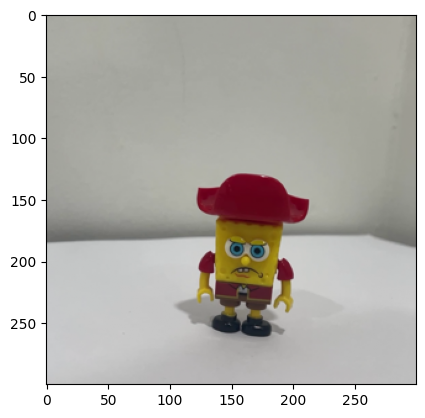

NeRF(
  (xyz_encoding_1): Sequential(
    (0): Linear(in_features=63, out_features=256, bias=True)
    (1): ReLU(inplace=True)
  )
  (xyz_encoding_2): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): ReLU(inplace=True)
  )
  (xyz_encoding_3): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): ReLU(inplace=True)
  )
  (xyz_encoding_4): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): ReLU(inplace=True)
  )
  (xyz_encoding_5): Sequential(
    (0): Linear(in_features=319, out_features=256, bias=True)
    (1): ReLU(inplace=True)
  )
  (xyz_encoding_6): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): ReLU(inplace=True)
  )
  (xyz_encoding_7): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): ReLU(inplace=True)
  )
  (xyz_encoding_8): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): ReLU(inpla

In [ ]:
# Set seed.
seed = 9458
torch.manual_seed(seed)
np.random.seed(seed)

device = "cuda:0"
F_c = NeRF().to(device)
F_f = NeRF().to(device)
chunk_size = 1024 * 32
batch_img_size = 64
n_batch_pix = batch_img_size ** 2

lr = 5e-4
optimizer = optim.Adam(list(F_c.parameters()) + list(F_f.parameters()), lr=lr)
criterion = nn.MSELoss()
lrate_decay = 250
decay_steps = lrate_decay * 1000
decay_rate = 0.1

# Load dataset.
data_f = "/content/drive/MyDrive/spongee.npz"
data = np.load(data_f)

images = data["rgb"]
img_size = images.shape[1]
xs = torch.arange(img_size) - (img_size / 2 - 0.5)
ys = torch.arange(img_size) - (img_size / 2 - 0.5)
(xs, ys) = torch.meshgrid(xs, -ys, indexing="xy")
focal = float(data["focal"])
pixel_coords = torch.stack([xs, ys, torch.full_like(xs, -focal)], dim=-1)
camera_coords = pixel_coords / focal
init_ds = camera_coords.to(device)
init_o = torch.Tensor(np.array([0, 0, 2.25])).to(device)

test_idx = 29
plt.imshow(images[test_idx])
plt.show()
test_img = torch.Tensor(images[test_idx]).to(device)
poses = data["poses"]
test_R = torch.Tensor(poses[test_idx, :3, :3]).to(device)
test_ds = torch.einsum("ij,hwj->hwi", test_R, init_ds)
test_os = (test_R @ init_o).expand(test_ds.shape)

t_n = 1.0
t_f = 4.0
N_c = 64
N_f = 128
t_i_c_gap = (t_f - t_n) / N_c
t_i_c_bin_edges = (t_n + torch.arange(N_c) * t_i_c_gap).to(device)

# Start training model.
train_idxs = np.arange(len(images)) != test_idx
images = torch.Tensor(images[train_idxs])
poses = torch.Tensor(poses[train_idxs])
n_pix = img_size ** 2
pixel_ps = torch.full((n_pix,), 1 / n_pix).to(device)
psnrs = []
iternums = []
# See Section 5.3.
num_iters = 300
display_every = 100
F_c.train()
F_f.train()

In [ ]:
embedding_xyz = Embedding(3, 10)
embedding_dir = Embedding(3, 4)
#models = [F_c, F_f]
embeddings = [embedding_xyz, embedding_dir]
#bins=
#(_, weights)=
#rays=sample_pdf(bins, weights, N_importance=64, det=False, eps=1e-5)
for i in range(num_iters):
    target_img_idx = np.random.randint(images.shape[0])
    target_pose = poses[target_img_idx].to(device)
    R = target_pose[:3, :3]

    ds = torch.einsum("ij,hwj->hwi", R, init_ds)
    os = (R @ init_o).expand(ds.shape)

    pix_idxs = pixel_ps.multinomial(n_batch_pix, False)
    pix_idx_rows = pix_idxs // img_size
    pix_idx_cols = pix_idxs % img_size
    ds_batch = ds[pix_idx_rows, pix_idx_cols].reshape(
        batch_img_size, batch_img_size, -1
    )
    os_batch = os[pix_idx_rows, pix_idx_cols].reshape(
        batch_img_size, batch_img_size, -1
    )


    (C_rs_c, C_rs_f) = render_rays(models,
                embeddings,
                rays,
                N_samples=64,
                use_disp=False,
                perturb=0,
                noise_std=1,
                N_importance=0,
                chunk=1024*32,
                white_back=False,
                test_time=False
                )

    # Run NeRF.
    '''(C_rs_c, C_rs_f) = run_one_iter_of_nerf(
        ds_batch,
        N_c,
        t_i_c_bin_edges,
        t_i_c_gap,
        os_batch,
        chunk_size,
        F_c,
        N_f,
        t_f,
        F_f,
    )'''
    target_img = images[target_img_idx].to(device)
    target_img_batch = target_img[pix_idx_rows, pix_idx_cols].reshape(F_f.shape)
    loss = criterion(F_c, target_img_batch) + criterion(F_f, target_img_batch)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    for g in optimizer.param_groups:
        g["lr"] = lr * decay_rate ** (i / decay_steps)

    if i % display_every == 0:
        F_c.eval()
        F_f.eval()
        '''with torch.no_grad():
            (_, C_rs_f) = run_one_iter_of_nerf(
                test_ds,
                N_c,
                t_i_c_bin_edges,
                t_i_c_gap,
                test_os,
                chunk_size,
                F_c,
                N_f,
                t_f,
                F_f,
            )'''

        loss = criterion(F_f, test_img)
        print(f"Loss: {loss.item()}")
        psnr = -10.0 * torch.log10(loss)

        psnrs.append(psnr.item())
        iternums.append(i)

        plt.figure(figsize=(10, 4))
        plt.subplot(121)
        plt.imshow(F_f.detach().cpu().numpy())
        plt.title(f"Iteration {i}")
        plt.subplot(122)
        plt.plot(iternums, psnrs)
        plt.title("PSNR")
        plt.show()

        F_c.train()
        F_f.train()

print("Done!")

AttributeError: ignored

In [ ]:
%matplotlib inline
from ipywidgets import interactive, widgets
import numpy as np
import torch
import torchvision.transforms.functional as F
from torchvision.transforms import InterpolationMode
from torch.autograd import grad
import torch.nn.functional as nnF

# checkpoint = torch.load('/content/nerf_model.pth')
# F_c.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# iteration = checkpoint['iteration']
# loss = checkpoint['loss']
# psnrs = checkpoint['psnrs']
# iternums = checkpoint['iternums']
# C_rs_c = checkpoint['C_rs_c']
# C_rs_f = checkpoint['C_rs_f']


def trans_t(t):
  return torch.tensor([
  [1,0,0,0],
  [0,1,0,0],
  [0,0,1,t],
  [0,0,0,1],
  ], dtype=torch.float32)

def rot_phi(phi):
    phi = torch.tensor(phi)
    return torch.tensor([
        [1, 0, 0, 0],
        [0, torch.cos(phi), -torch.sin(phi), 0],
        [0, torch.sin(phi), torch.cos(phi), 0],
        [0, 0, 0, 1],
    ], dtype=torch.float32)

def rot_theta(th):
    th = torch.tensor(th)
    return torch.tensor([
        [torch.cos(th), 0, -torch.sin(th), 0],
        [0, 1, 0, 0],
        [torch.sin(th), 0, torch.cos(th), 0],
        [0, 0, 0, 1],
    ], dtype=torch.float32)

def pose_spherical(theta, phi, radius):
  c2w = trans_t(radius)
  c2w = rot_phi(phi/180.*np.pi) @ c2w
  c2w = rot_theta(theta/180.*np.pi) @ c2w
  c2w = torch.tensor([[-1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]], dtype=torch.float32) @ c2w
  return c2w

def f(**kwargs):
  c2w = pose_spherical(**kwargs)
  c2w = c2w.to(device)
  test_R = torch.Tensor(poses[test_idx, :3, :3]).to(device)
  test_R = c2w[:3, :3].to(device)
  test_ds = torch.einsum("ij,hwj->hwi", test_R, init_ds)
  test_os = (test_R @ init_o).expand(test_ds.shape)
  with torch.no_grad():
            (_, C_rs_f) = run_one_iter_of_nerf(
                test_ds,
                N_c,
                t_i_c_bin_edges,
                t_i_c_gap,
                test_os,
                chunk_size,
                F_c,
                N_f,
                t_f,
                F_f,
            )
  img = torch.clamp((C_rs_f.detach()), 0, 1)
  img = img.permute(2, 0, 1)

  img_np = img.cpu().numpy()
  plt.figure(2, figsize=(20,6))
  plt.imshow(img_np.transpose(1, 2, 0))
  plt.show()

sldr = lambda v, mi, ma: widgets.FloatSlider(
  value=v,
  min=mi,
  max=ma,
  step=.01,
)

names = [
  ['theta', [100., 0., 360]],
  ['phi', [-30., 0, 360]],
  ['radius', [4., 3., 5.]],
]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
interactive_plot = interactive(f, **{s[0] : sldr(*s[1]) for s in names})
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(FloatSlider(value=100.0, description='theta', max=360.0, step=0.01), FloatSlider(value=0…

In [ ]:
frames = []
from tqdm import tqdm_notebook as tqdm
for th in tqdm(np.linspace(0., 360., 120, endpoint=False)):
    c2w = pose_spherical(th, -30., 4.)
    test_R = torch.Tensor(poses[test_idx, :3, :3]).to(device)
    test_R = c2w[:3, :3].to(device)
    test_ds = torch.einsum("ij,hwj->hwi", test_R, init_ds)
    test_os = (test_R @ init_o).expand(test_ds.shape)
    with torch.no_grad():
            (_, C_rs_f) = run_one_iter_of_nerf(
                test_ds,
                N_c,
                t_i_c_bin_edges,
                t_i_c_gap,
                test_os,
                chunk_size,
                F_c,
                N_f,
                t_f,
                F_f,
            )
    frames.append((C_rs_f.detach().cpu().numpy()).astype(np.uint8))

import cv2

frames_resized = []
for frame in frames:
    frame_resized = cv2.resize(frame, (304, 304))
    frames_resized.append(frame_resized)

import imageio
f = 'video.mp4'
imageio.mimwrite(f, frames_resized, fps=30, quality=7)

<ipython-input-7-73df42f9facd>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for th in tqdm(np.linspace(0., 360., 120, endpoint=False)):


  0%|          | 0/120 [00:00<?, ?it/s]

In [ ]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('video.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls autoplay loop>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)